# Nous allons choisir la décennie 1960-1969

In [2]:
DECADE = '1960'

# Nous allons effectuer le clustering des documents de notre décennie

### imports

In [3]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

### téléchargements

In [4]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Définition de la variable contenant le chemin vers les fichiers textes

In [6]:
data_path = "../data/txt/"

### Charger tous les  fichiers de la décennie et en créer une liste de textes

In [11]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

### Charger les textes des fichiers de la décennie

In [12]:
texts = [open(data_path + f).read() for f in files]

### Définition de la fonction de prétraitement

In [13]:
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Les différents blocs de traitements des mots

In [14]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [15]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 2min 10s, sys: 0 ns, total: 2min 10s
Wall time: 2min 11s


### Le nombre de cluster que nous avons choisi est de 10

In [16]:
N_CLUSTERS = 10

In [17]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [18]:
clusters = km_model.fit_predict(tfidf_vectors)

In [19]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [20]:
pprint(dict(clustering))

{0: ['Bxl_1960_Tome_I_Part_7.txt',
     'Bxl_1961_Tome_I_Part_8.txt',
     'Bxl_1962_Tome_I_Part_10.txt',
     'Bxl_1962_Tome_I_Part_9.txt',
     'Bxl_1963_Tome_I_Part_9.txt',
     'Bxl_1964_Tome_I_Part_10.txt',
     'Bxl_1964_Tome_I_Part_9.txt',
     'Bxl_1965_Tome_II2_Part_5.txt',
     'Bxl_1965_Tome_I_Part_10.txt',
     'Bxl_1965_Tome_I_Part_11.txt',
     'Bxl_1965_Tome_I_Part_8.txt',
     'Bxl_1965_Tome_I_Part_9.txt',
     'Bxl_1966_Tome_I1_Part_2.txt',
     'Bxl_1966_Tome_I1_Part_3.txt',
     'Bxl_1966_Tome_I2_Part_2.txt',
     'Bxl_1966_Tome_I2_Part_3.txt',
     'Bxl_1966_Tome_II1_Part_9.txt',
     'Bxl_1967_Tome_I1_Part_2.txt',
     'Bxl_1967_Tome_II1_Part_7.txt',
     'Bxl_1968_Tome_I1_Part_6.txt',
     'Bxl_1968_Tome_I1_Part_7.txt',
     'Bxl_1968_Tome_II2_Part_11.txt',
     'Bxl_1968_Tome_II2_Part_12.txt'],
 1: ['Bxl_1960_Tome_II1_Part_3.txt',
     'Bxl_1960_Tome_II1_Part_5.txt',
     'Bxl_1960_Tome_II2_Part_3.txt',
     'Bxl_1960_Tome_II2_Part_4.txt',
     'Bxl_1960_Tome_I_P

In [21]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

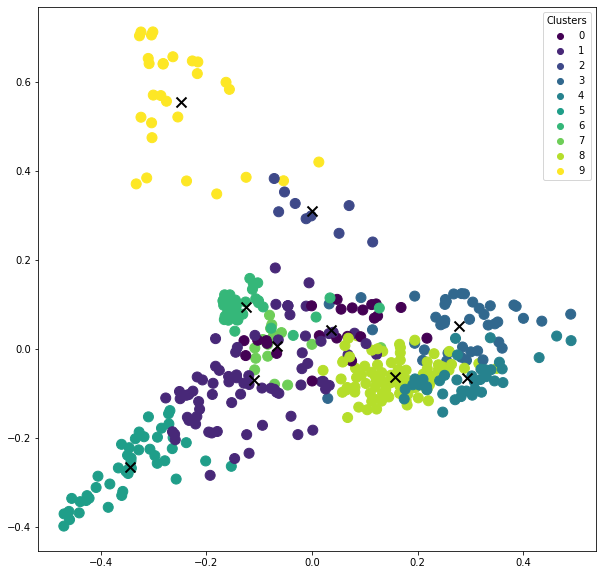

In [22]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Entraitenement de représentation des mots

### imports

In [23]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

### Chargement et traitement des phrases du corpus

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [24]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [25]:
infile = f"../data/sent.txt"
sentences = MySentences(infile)

sentences = [sentence for sentence in sentences]

### Détection des bigrams

In [26]:
bigram_phrases = Phrases(sentences)

### Conversion des `Phrases` en objet `Phraser`

In [27]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [28]:
trigram_phrases = Phrases(bigram_phraser[sentences])

### Conversion des `Phrases` en objet `Phraser`

In [29]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [30]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

### Entrainement d'un modèle Word2Vec sur ce corpus

In [31]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 32.5 s, sys: 829 ms, total: 33.3 s
Wall time: 15.4 s


In [33]:
outfile = f"../data/bulletins.model"
model.save(outfile)

In [34]:
model = Word2Vec.load("../data/bulletins.model")

In [35]:
model.wv["hospice"]

array([ 1.883774  ,  0.04774521,  2.169398  , -5.4908013 , -0.5555667 ,
       -2.3992465 ,  2.3867662 ,  1.5284927 , -5.029468  , -1.7236607 ,
        0.2358847 , -1.3557737 ,  1.2627453 , -1.278157  , -1.1677384 ,
       -0.9741052 , -1.853714  ,  2.596454  , -0.55908614, -1.7815979 ,
       -1.5959294 ,  0.53626657, -0.48771197, -2.5346043 , -3.7472825 ,
        1.0076554 , -1.7199033 , -2.963187  , -3.1899648 ,  2.1748445 ,
        0.8926174 , -0.7614855 ], dtype=float32)

### Calculer la similarité entre deux termes

In [36]:
model.wv.similarity("realisation", "communication")

0.598168

### Chercher les mots les plus proches d'un terme donné

In [37]:
model.wv.most_similar("communication", topn=10)

[('reclamation', 0.7630351185798645),
 ('commission_speciale', 0.7514122128486633),
 ('nomination', 0.7361952066421509),
 ('petition', 0.731803297996521),
 ('transaction', 0.7155613303184509),
 ('rectification', 0.7150698304176331),
 ('redaction', 0.7050889730453491),
 ('interpellation', 0.7017675638198853),
 ('commission_chargee', 0.7002929449081421),
 ('revision', 0.697712242603302)]

### Faire des recherches complexes à travers l'espace vectoriel

In [44]:
print(model.wv.most_similar(positive=['administration', 'philanthropie'], negative=['belgique']))

[('envoyer', 0.7572186589241028), ('approbation', 0.7475339770317078), ('aux_fins', 0.7473394870758057), ('autorite_superieure', 0.7447587251663208), ('nistration', 0.7378610968589783), ('conseil_general', 0.7343752980232239), ('secours_demande', 0.7311606407165527), ('attraire_en_justice', 0.7037755846977234), ("'_autorite_competente", 0.6863450407981873), ('accepter', 0.6681413650512695)]


## 6. Exploration du modèle

In [38]:
model.wv.similarity("institution", "administration")

0.52307963

In [39]:
model.wv.similarity("institution", "etablissement")

0.74910104

In [40]:
model.wv.similarity("hospice", "hopital")

0.765688

In [41]:
model.wv.most_similar("institution", topn=10)

[('organisation', 0.916873574256897),
 ('amelioration', 0.8743342757225037),
 ('expertise', 0.8556596040725708),
 ('nomination', 0.8364729881286621),
 ('appreciation', 0.8357993364334106),
 ('occasion', 0.8168162703514099),
 ('application', 0.8163925409317017),
 ('intervention', 0.8140579462051392),
 ('extension', 0.8112512826919556),
 ('utilite', 0.8064790964126587)]

In [42]:
model.wv.most_similar("hopital", topn=10)

[('hopital_st_.-_jean', 0.8260793685913086),
 ('eclairage', 0.7690408229827881),
 ('hospice', 0.7656880617141724),
 ('abattoir', 0.7499976754188538),
 ('entrepot', 0.7395710349082947),
 ('ecole', 0.7361373901367188),
 ('amigo', 0.7270328998565674),
 ('escalier', 0.7265223264694214),
 ('eglise', 0.722158670425415),
 ('aqueduc', 0.7179761528968811)]

In [43]:
model.wv.most_similar("etablissement", topn=10)

[('achevement', 0.8630293607711792),
 ('agrandissement', 0.8519876003265381),
 ('usage', 0.8384042978286743),
 ('industrie', 0.8371788859367371),
 ('entreprise', 0.836018443107605),
 ('edifice', 0.8348572850227356),
 ('erection', 0.8330942988395691),
 ('embellissement', 0.8163767457008362),
 ('admission', 0.8074764013290405),
 ('assainissement', 0.8043556213378906)]